In [77]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ccdproc
from ccdproc import ImageFileCollection as IFC
from astropy.nddata import CCDData
from astropy.modeling import models, fitting, powerlaws
from astropy import units as u
from astropy import constants as const
from scipy.stats import linregress

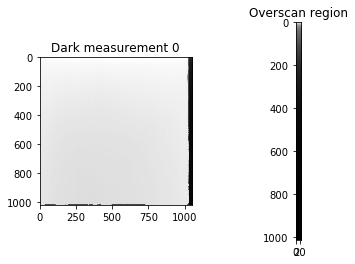

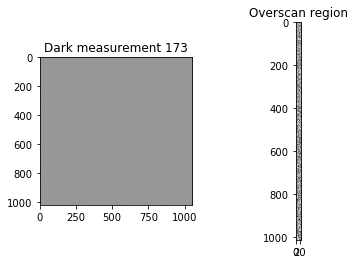

In [3]:
# from dark measurement read temperature and count median, standard deviation
#
# To read .fits file use IFC(<path_to_files>, glob_include = file name start*, keywords = interested key in header)
# The structure of a .fits file is Header Data Units(HDU)
# Each HDU contains .header (header information ~ key-value pair, labels of data) and .data (image information ~ array)
# To get value of header information use IFC(...).values(<key>) or IFC(...).summary[<key>].data
# More info: https://ccdproc.readthedocs.io/en/latest/api/ccdproc.ImageFileCollection.html#ccdproc.ImageFileCollection.hdus
#
dark = IFC('.\Template_scripts\darks\\',glob_include='dark_*', keywords=['ccdtemp', 'datamedi', 'datastdv']) 
temp,med,stddev=np.asarray(dark.values("ccdtemp"))+273.15,np.asarray(dark.values("datamedi")),np.asarray(dark.values("datastdv"))

# use program ds9 we read the overscan region(= bias region) for dark_0000.fits is about (row[10:1024] colomn[1025:1050])
# a list of median bias values and the standard deviations in the overscan region
bias_med = []
bias_std = []

for idx, hdu in enumerate(dark.hdus(save_with_name = "-bias", save_location = '.\Template_scripts\darks-bias\\', 
                                    overwrite = True)):
    bias = CCDData(hdu.data[10:1024,1025:1050], unit="electron")
    bias_med.append(np.median(np.asarray(bias)))
    bias_std.append(np.std(np.asarray(bias)))
    # Correct each of the dark measurements with their corresponding median bias value
    hdu.data = hdu.data - np.median(np.asarray(bias))
    if idx == 0 or idx == 173:
        # plot of the whole image
        pic = CCDData(hdu.data, unit="electron") # convert hdu(array) to pic(CCDData) first
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(pic, cmap='Greys_r')
        ax1.set_title("Dark measurement " + str(idx))
        # plot of overscan region
        ax2.imshow(bias, cmap='Greys_r')
        ax2.set_title("Overscan region")
        plt.show()
            
# TODO: Why do we have to determine and subtract the bias value for every image individually?
# 

In [4]:
# Extract the median dark current values of the bias-subtracted FITS files of the dark measurements
dark_no_bias = IFC('.\Template_scripts\darks-bias\\',glob_include='dark_*', keywords=['datamedi', 'datastdv']) 

med_no_bias = []
stddev_no_bias = []
# use program ds9 we read the image region for dark_0000.fits is about (row[30:1014] colomn[0:1010])
for hdu in dark_no_bias.hdus():
    img = CCDData(hdu.data[30:1014,0:1010], unit="electron")
    med_no_bias.append(np.median(np.asarray(img)))
    stddev_no_bias.append(np.std(np.asarray(img)))

# Determine the bias and its scatter for two images, one at the beginning of the experiment and one at the end.
print("Bias of the 0. image: ", bias_med[0], "+/-", round(bias_std[0],1))
print("Bias of the last image: ", bias_med[-1], "+/-", round(bias_std[-1],1))
print("Scatter of the 0. image: ", med_no_bias[0], "+/-", round(stddev_no_bias[0],1))
print("Scatter of the last image: ", med_no_bias[-1], "+/-", round(stddev_no_bias[-1],1))

Bias of the 0. image:  2029.0 +/- 1444.8
Bias of the last image:  1350.0 +/- 1.7
Scatter of the 0. image:  52234.0 +/- 3161.9
Scatter of the last image:  0.0 +/- 3.5


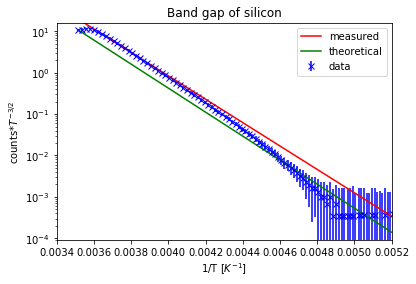

Band gap of silicon =  1.1205 +\- 0.0061 eV
Literature value = 1.15 eV


In [5]:
# dark measurement analysis
# Verify the dependency according to eq. 14 by plotting the data and the theoretical curve in a sensible plot 
def expon(x,A,k): 
    return A*np.exp(x*k)
para, paraerr = curve_fit(expon, 1/temp[4:100], (med_no_bias*temp**(-3/2))[4:100], p0 = (3.2e10, -6000))
E_g = para[1]*u.K*(-2*const.k_B)
E_g_err = np.sqrt(paraerr[1][1])*u.K*(2*const.k_B)
plt.plot(1/temp, expon(1/temp, para[0], para[1]), label='measured', color='red')
plt.plot(1/temp, expon(1/temp, para[0], ((1.15*u.eV).to(u.J)/(-2*const.k_B)).value), label = 'theoretical', color = 'green')
plt.errorbar(1/temp, med_no_bias*temp**(-3/2), yerr=stddev_no_bias*temp**(-3/2), marker='x', ls='none', color='blue', label = 'data')
plt.xlabel("1/T [$K^{-1}$]")
plt.ylabel("counts*$T^{-3/2}$")
plt.yscale('log')
plt.title("Band gap of silicon")
plt.axis([0.0034, 0.0052, 9e-5, 16])
plt.legend()
plt.show()
# Determine the band gap of the detector chip by fitting the dependency.
print("Band gap of silicon = ",round(E_g.to(u.eV).value,4),"+\-",round(E_g_err.to(u.eV).value,4), "eV")
print("Literature value = 1.15 eV")

# TODO: Discuss reasons for possible deviations from the expected band gap value.

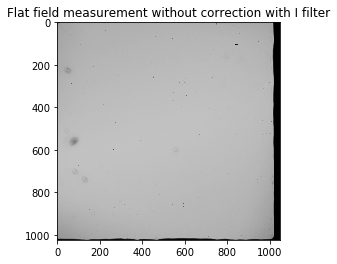

C:\Users\Yajie\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


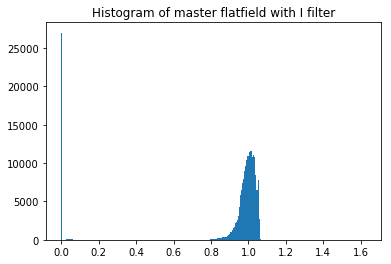

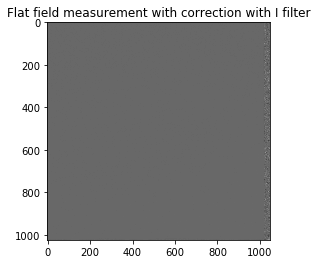

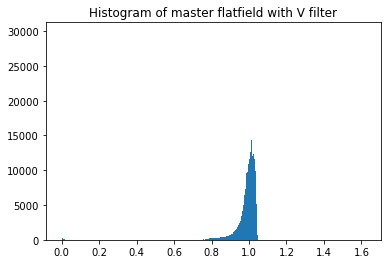

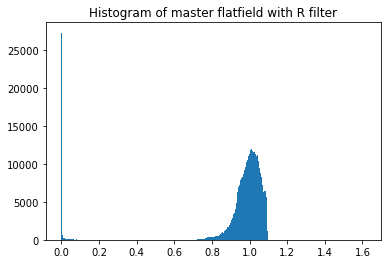

In [66]:
# read flat field measurement
flat_I = IFC('.\Template_scripts\\flats\\',glob_include='flat_I_*',glob_exclude='*test*', keywords=['exptime', 'ccdtemp'])
flat_V = IFC('.\Template_scripts\\flats\\',glob_include='flat_V_*', keywords=['exptime', 'ccdtemp'])
flat_R = IFC('.\Template_scripts\\flats\\',glob_include='flat_R_*',glob_exclude='*test*', keywords=['exptime', 'ccdtemp'])

# dark_0173-bias.fits is measured at T = -106.1°C, flat fields are measured at T = 108°C ~ 110°C
bias_last = bias_med[-1]

# I filter
flat_list = []
for idx, hdu in enumerate(flat_I.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    if idx == 0:
        plt.imshow(dat, cmap='Greys_r')
        plt.title("Flat field measurement without correction with I filter")
        plt.show()
    # subtract the bias from the individual flat-field images
    dat.data = dat.data - bias_last
    flat_list.append(dat)
    
# Combine the individual flat-field images to a single image (the master flatfield) 
master_flat_I = ccdproc.Combiner(flat_list).median_combine()
# normalize the master flat-field by dividing it by its median (why?)
master_flat_I = master_flat_I/np.median(master_flat_I)
# obtain a histogram for this master flatfield
plt.hist(master_flat_I.ravel(), bins='auto')
plt.title("Histogram of master flatfield with I filter")
plt.show()

for idx, hdu in enumerate(flat_I.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    dat.data = dat.data - bias_last
    # Perform a flat-field correction (i.e., divide the image by the normalized master flat-field)
    dat.data = dat.data/master_flat_I
    plt.imshow(dat, cmap='Greys_r')
    plt.title("Flat field measurement with correction with I filter")
    plt.show()
    break

# V filter
flat_list = []
for idx, hdu in enumerate(flat_V.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # subtract the bias from the individual flat-field images
    dat.data = dat.data - bias_last
    flat_list.append(dat)
    
# Combine the individual flat-field images to a single image (the master flatfield)
master_flat_V = ccdproc.Combiner(flat_list).median_combine()
# normalize the master flat-field by dividing it by its median (why?)
master_flat_V = master_flat_V/np.median(master_flat_V)
# obtain a histogram for this master flatfield
plt.hist(master_flat_V.ravel(), bins='auto')
plt.title("Histogram of master flatfield with V filter")
plt.show()

# R filter
flat_list = []
for idx, hdu in enumerate(flat_R.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # subtract the bias from the individual flat-field images
    dat.data = dat.data - bias_last
    flat_list.append(dat)
    
# Combine the individual flat-field images to a single image (the master flatfield)
master_flat_R = ccdproc.Combiner(flat_list).median_combine()
# normalize the master flat-field by dividing it by its median (why?)
master_flat_R = master_flat_R/np.median(master_flat_R)
# obtain a histogram for this master flatfield
plt.hist(master_flat_R.ravel(), bins='auto')
plt.title("Histogram of master flatfield with R filter")
plt.show()


#
#TODO:
#Why do we have to normalize the master flat-field? 
#How many pixels of the master flatfield have a value close to 1 as expected and where do the deviations come from?
#Why do we need to divide all of our observations by a master flat-field?
#Why do we use the median of the pixels for the image combination and for the normalization and not, 
#    for example, the mean value?
#Why was it necessary to set the illumination di↵erently for each filter?
#Why do we have to measure the CCD response to a ”flat” surface? 
#    Why are the nails holding the blanket and the warped surface of the blanket itself not detrimental to the dome flat?
#

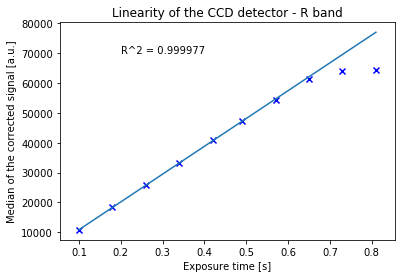

The detector saturates at approximately 64160.3 counts for a gain factor of 5.


In [88]:
# from linearity measurement read exposure time 
lin = IFC('.\Template_scripts\linearity\\',glob_include='linearity_R_*',keywords=['exptime'])
exptime = lin.summary['exptime'].data

lin_list = []
lin_med_bias = []
lin_stddev_bias = []
lin_med_ff = []
lin_stddev_ff = []
for idx, hdu in enumerate(lin.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # bias correction
    dat.data = dat.data - bias_last
    lin_med_bias.append(np.median(dat.data))
    lin_stddev_bias.append(np.std(dat.data))
    # flat field correction
    dat.data = dat.data/master_flat_R
    lin_med_ff.append(np.median(dat.data))
    lin_stddev_ff.append(np.std(dat.data))

# Verify the linearity of the chip by plotting the signal of each flat-field-corrected image against its integration time
plt.scatter(exptime, lin_med_ff, marker='x', color='blue', label = 'data')
# Determine the deviation from a perfect linear relationship and specify the intensity where saturation sets in
slope, intercept, r_value, p_value, std_err = linregress(exptime[:-3], lin_med_ff[:-3])
plt.plot(exptime, slope*exptime+intercept)
plt.text(0.2, 7e4, "R^2 = "+str(round(r_value,6)))
plt.title("Linearity of the CCD detector - R band")
plt.ylabel("Median of the corrected signal [a.u.]")
plt.xlabel("Exposure time [s]")
plt.show()
print("The detector saturates at approximately", round(np.average(lin_med_ff[-2:]),1),"counts for a gain factor of 5.")

# TODO: Estimate the error of the measurement from the standard deviation of the pixel values. (How?)

C:\Users\Yajie\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


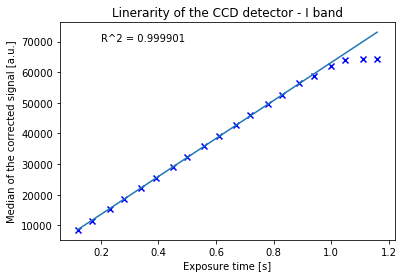

The detector saturates at approximately 64141.4 counts for a gain factor of 5.


In [94]:
# from sensitivity measurement read exposure time 
# TODO: why it measured twice with _1_ and _2_ ?
sen = IFC('.\Template_scripts\sensitivity\\',glob_include='sensitivity_I_1_*',keywords=['exptime'])
sen2 = IFC('.\Template_scripts\sensitivity\\',glob_include='sensitivity_I_2_*',keywords=['exptime'])
exptime_sen = sen.summary['exptime'].data

sen_list = []
sen_med_bias = []
sen_stddev_bias = []
sen_med_ff = []
sen_stddev_ff = []
for idx, hdu in enumerate(sen.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # bias correction
    dat.data = dat.data - bias_last
    sen_med_bias.append(np.median(dat.data))
    sen_stddev_bias.append(np.std(dat.data))
    # flat field correction
    dat.data = dat.data/master_flat_I
    sen_med_ff.append(np.median(dat.data))
    sen_stddev_ff.append(np.std(dat.data))

# Verify the linearity of the chip by plotting the signal of each flat-field-corrected image against its integration time
plt.scatter(exptime_sen, sen_med_ff, marker='x', color='blue', label = 'data')
# Determine the deviation from a perfect linear relationship and specify the intensity where saturation sets in
slope, intercept, r_value, p_value, std_err = linregress(exptime_sen[:-4], sen_med_ff[:-4])
plt.plot(exptime_sen, slope*exptime_sen+intercept)
plt.text(0.2, 7e4, "R^2 = "+str(round(r_value,6)))
plt.title("Linerarity of the CCD detector - I band")
plt.ylabel("Median of the corrected signal [a.u.]")
plt.xlabel("Exposure time [s]")
plt.show()
print("The detector saturates at approximately", round(np.average(sen_med_ff[-3:]),1),"counts for a gain factor of 5.")

# Estimate the error of the measurement from the standard deviation of the pixel values. (how?)

In [108]:
# Sensitivity of the detector and noise properties
# TODO: not so sure about that part
ita = 1. # the quantum efficiency, assuming = 1
kappa = 5. # electron seneitivity
f_PRNU = 0.01

# in the following sig_* meaning (sig_*)^2
N_e_d = []
N_e_d2 = []

for idx, (hdu, hdu2) in enumerate(zip(sen.hdus(),sen2.hdus())):
    dat = CCDData(hdu.data, unit="electron")
    dat2 = CCDData(hdu2.data, unit="electron")
    # Determine the read-out noise from the overscan region \sigma_R from one pair of pictures
    if idx == 0:
        sig_R = np.median(dat.data[10:1024,1025:1050])
        sig_R2 = np.median(dat2.data[10:1024,1025:1050])
    # Use ds9 to choose at least a 200 x 200 pixel region that is uniformly illuminated near the center of the image
    # in our case x[303:502] y[296:495], see pic "sensitivity_region"
    # extract median signal within the chosen regions
    N_e_d.append(np.median(dat[303:502, 296:495])*(ita/kappa))
    N_e_d2.append(np.median(dat2[303:502, 296:495])*(ita/kappa))
    # subtract the signal of one image from the other
    diffdat = dat.data - dat2.data
    # TODO:
    # Plot the variance of the signal versus the signal itself with increasing exposure times in the I-filter 
    # extract the electron sensitivity kappa using eq. 23. Explain what this plot means
    #
    # Calculate kappa using eq. 19 and explain discrepancies with previous method. 
    # Do the calculation for just one image with average counts ~30000 ADU
    #
    # Discuss the quality of the analogue digital converter
    
# determine the total noise
N_e_d = np.asarray(N_e_d)
N_e_d2 = np.asarray(N_e_d2)
sig_e_d = N_e_d*(ita/kappa)
sig_PRNU = f_PRNU * N_e_d * (kappa/ita)
sig_tot = sig_e_d + sig_R + sig_PRNU
sig_e_d2 = N_e_d2*(ita/kappa)
sig_PRNU2 = f_PRNU * N_e_d2 * (kappa/ita)
sig_tot2 = sig_e_d2 + sig_R2 + sig_PRNU2
# Determine the noise in the difference image within the chosen region
sig_diff_d = 2*(sig_R + (N_e_d + N_e_d2)/2*(ita/kappa))
print(sig_diff_d)

# Find and discuss the photon noise, the read-out noise, and the PRNU noise for one flat image
print("Let's take the first image for example:")
print("the photon noise: ", round(sig_e_d[0],2))
print("the read-out noise: ", sig_R)
print("the PRNU noise: ", round(sig_PRNU[0],2))
# TODO: Which noise dominates? Explain.

[3551.32 3800.16 4103.72 4354.4  4657.12 4908.88 5210.44 5463.48 5767.36
 6015.92 6316.32 6562.04 6859.2  7102.04 7390.56 7577.4  7842.28 7960.8
 7960.8  7960.8 ]
Let's take the first image for example:
the photon noise:  417.28
the read-out noise:  1359.0
the PRNU noise:  104.32
